<h1 style="padding-top: 25px;padding-bottom: 25px;text-align: left; padding-left: 10px; background-color: #DDDDDD;
    color: black;"> <img style="float: left; padding-right: 10px;" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png" height="50px"> <a href='https://harvard-iacs.github.io/2023-AC215/' target='_blank'><strong><font color="#A41034">AC215: Productionizing AI (MLOps)</font></strong></a></h1>

# **<font color="#A41034">Tutorial - Mushroom Classification Models, Experiment Tracking</font>**

**Harvard University**<br/>
**Fall 2023**<br/>
**Instructor:**<br/>
Pavlos Protopapas

<hr style="height:2pt">

## **<font color="#A41034">Setup Notebook</font>**

**Copy & setup Colab with GPU**

1) Select "File" menu and pick "Save a copy in Drive"  
2) This notebooks is already setup to use GPU but if you want to change it. Go to "Runtime" menu and select "Change runtime type". Then in the popup in "Hardware accelerator" select "GPU" and then click "Save"   
3) If you want high RAM there is an option for that

**Installs**

In [ ]:
!pip install -q wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 21.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.7 MB/s eta 0:00:00


**Imports**

In [ ]:
import os
import requests
import zipfile
import tarfile
import shutil
import math
import json
import time
import sys
import cv2
import string
import re
import subprocess
import hashlib
import numpy as np
import pandas as pd
from glob import glob
import collections
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils.layer_utils import count_params

# sklearn
from sklearn.model_selection import train_test_split

# Tensorflow Hub
import tensorflow_hub as hub

# W&B
import wandb
from wandb.keras import WandbCallback, WandbMetricsLogger

**Verify Setup**

It is a good practice to verify what version of TensorFlow & Keras you are using. Also verify if GPU is enabled and what GPU you have. Run the following cells to check the version of TensorFlow

References:
- [Eager Execution](https://www.tensorflow.org/guide/eager)
- [Data Performance](https://www.tensorflow.org/guide/data_performance)

In [ ]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately,
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

tensorflow version 2.13.0
Eager Execution Enabled: True
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Run this cell to see what GPU you have. If you get a P100 or T4 GPU that's great. If it's K80, it will still work but it will be slow.

In [ ]:
!nvidia-smi

Thu Sep 28 20:08:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    26W /  70W |    361MiB / 15360MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Utils**

Here are some util functions that we will be using for this notebook

In [ ]:
def download_file(packet_url, base_path="", extract=False, headers=None):
  if base_path != "":
    if not os.path.exists(base_path):
      os.mkdir(base_path)
  packet_file = os.path.basename(packet_url)
  with requests.get(packet_url, stream=True, headers=headers) as r:
      r.raise_for_status()
      with open(os.path.join(base_path,packet_file), 'wb') as f:
          for chunk in r.iter_content(chunk_size=8192):
              f.write(chunk)

  if extract:
    if packet_file.endswith(".zip"):
      with zipfile.ZipFile(os.path.join(base_path,packet_file)) as zfile:
        zfile.extractall(base_path)
    else:
      packet_name = packet_file.split('.')[0]
      with tarfile.open(os.path.join(base_path,packet_file)) as tfile:
        tfile.extractall(base_path)

def compute_dataset_metrics(data_list):
  data_list_with_metrics = []
  for item in data_list:
    # Read image
    image = cv2.imread(item[1])
    data_list_with_metrics.append((item[0],item[1],image.shape[0],image.shape[1],image.nbytes / (1024 * 1024.0)))

  # Build a dataframe
  data_list_with_metrics = np.asarray(data_list_with_metrics)
  dataset_df = pd.DataFrame({
    'label': data_list_with_metrics[:, 0],
    'path': data_list_with_metrics[:, 1],
    'height': data_list_with_metrics[:, 2],
    'width': data_list_with_metrics[:, 3],
    'size': data_list_with_metrics[:, 4],
    })

  dataset_df["height"] = dataset_df["height"].astype(int)
  dataset_df["width"] = dataset_df["width"].astype(int)
  dataset_df["size"] = dataset_df["size"].astype(float)

  dataset_mem_size = dataset_df["size"].sum()
  value_counts = dataset_df["label"].value_counts()
  height_details = dataset_df["height"].describe()
  width_details = dataset_df["width"].describe()

  print("Dataset Metrics:")
  print("----------------")
  print("Label Counts:")
  print(value_counts)
  print("Image Width:")
  print("Min:",width_details["min"]," Max:",width_details["max"])
  print("Image Height:")
  print("Min:",height_details["min"]," Max:",height_details["max"])
  print("Size in memory:",round(dataset_df["size"].sum(),2),"MB")

class JsonEncoder(json.JSONEncoder):
  def default(self, obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, decimal.Decimal):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return super(JsonEncoder, self).default(obj)

## **<font color="#A41034">Dataset</font>**

#### **Download**

In [ ]:
start_time = time.time()
download_file("https://github.com/dlops-io/datasets/releases/download/v1.0/mushrooms_3_labels.zip", base_path="datasets", extract=True)
execution_time = (time.time() - start_time)/60.0
print("Download execution time (mins)",execution_time)

Download execution time (mins) 0.17469817797342937


### **Load Data**

* Read-in data as lists.
* Each element in data_x is the path to the image
* Each element in data_y is the label of that image

In [ ]:
base_path = os.path.join("datasets","mushrooms")
label_names = os.listdir(base_path)
print("Labels:", label_names)

# Number of unique labels
num_classes = len(label_names)
# Create label index for easy lookup
label2index = dict((name, index) for index, name in enumerate(label_names))
index2label = dict((index, name) for index, name in enumerate(label_names))

# Generate a list of labels and path to images
data_list = []
for label in label_names:
  # Images
  image_files = os.listdir(os.path.join(base_path,label))
  data_list.extend([(label,os.path.join(base_path,label,f)) for f in image_files])

print("Full size of the dataset:",len(data_list))
print("data_list:",data_list[:5])

Labels: ['crimini', 'oyster', 'amanita']
Full size of the dataset: 1643
data_list: [('crimini', 'datasets/mushrooms/crimini/450.jpg'), ('crimini', 'datasets/mushrooms/crimini/28.jpg'), ('crimini', 'datasets/mushrooms/crimini/410.jpg'), ('crimini', 'datasets/mushrooms/crimini/570.jpg'), ('crimini', 'datasets/mushrooms/crimini/575.jpg')]


### **View Images**

Let's take a look at the data.

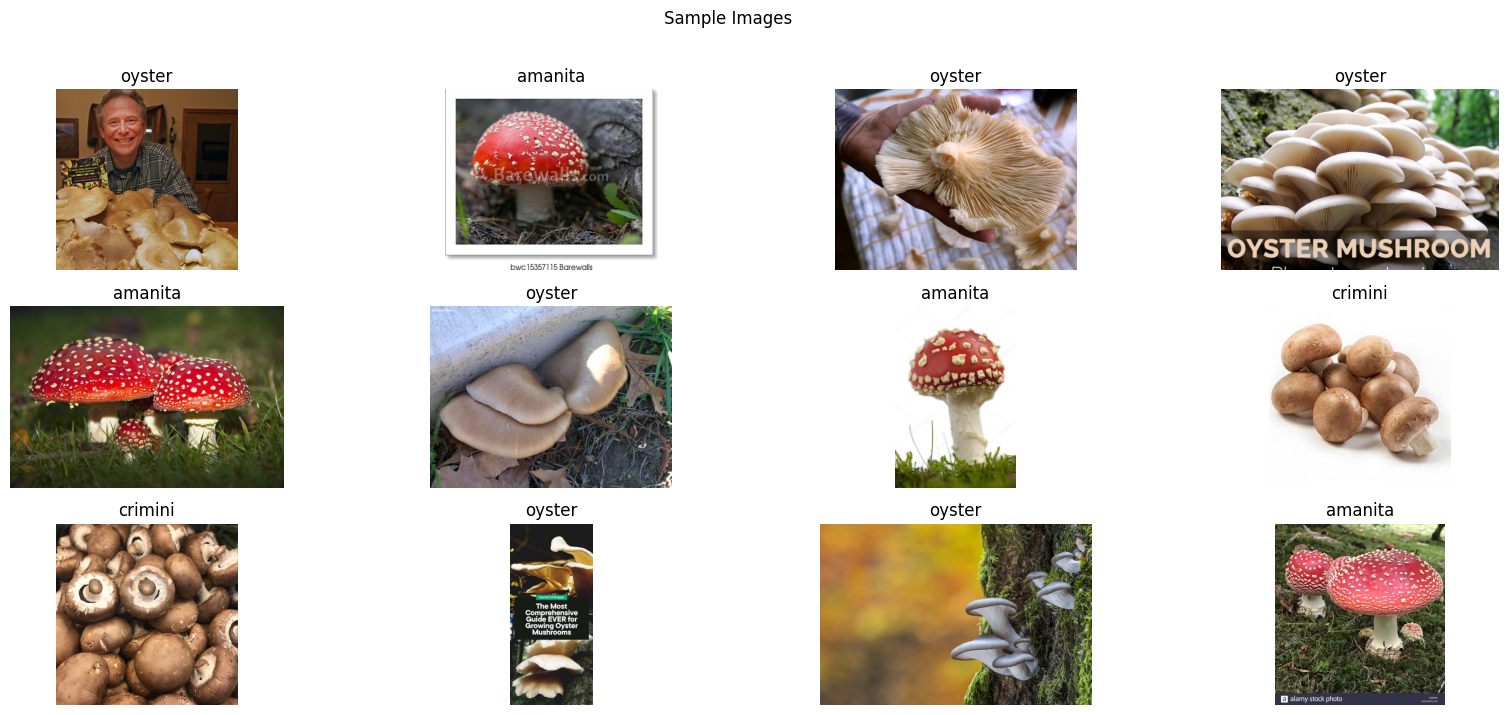

In [ ]:
# Generate a random sample of index
image_samples = np.random.randint(0,high=len(data_list)-1, size=12)

fig = plt.figure(figsize=(20,8))
for i,img_idx in enumerate(image_samples):
    axs = fig.add_subplot(3,4,i+1)
    axs.set_title(data_list[img_idx][0])
    # Read image
    image = cv2.imread(data_list[img_idx][1])
    # convert to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')

plt.suptitle("Sample Images")
plt.show()

## **<font color="#A41034">Build Data Pipelines</font>**

### **Load X & Y**

Generate data_x and data_y

In [ ]:
# Build data x, y
data_x = [itm[1] for itm in data_list]
data_y = [itm[0] for itm in data_list]

print("data_x:",len(data_x))
print("data_y:",len(data_y))
print("data_x:",data_x[:5])
print("data_y:",data_y[:5])

data_x: 1643
data_y: 1643
data_x: ['datasets/mushrooms/crimini/450.jpg', 'datasets/mushrooms/crimini/28.jpg', 'datasets/mushrooms/crimini/410.jpg', 'datasets/mushrooms/crimini/570.jpg', 'datasets/mushrooms/crimini/575.jpg']
data_y: ['crimini', 'crimini', 'crimini', 'crimini', 'crimini']


### **Split Data**
We split data into test, validation, & train

In [ ]:
test_percent = 0.10
validation_percent = 0.2

# Split data into train / test
train_validate_x, test_x, train_validate_y, test_y = train_test_split(data_x, data_y, test_size=test_percent)

# Split data into train / validate
train_x, validate_x, train_y, validate_y = train_test_split(train_validate_x, train_validate_y, test_size=test_percent)

print("train_x count:",len(train_x))
print("validate_x count:",len(validate_x))
print("test_x count:",len(test_x))

train_x count: 1330
validate_x count: 148
test_x count: 165


### **Create TF Datasets**

In [ ]:
def get_dataset(image_width = 224, image_height = 224, num_channels = 3, batch_size = 32):

  # Load Image
  def load_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=num_channels)
    image = tf.image.resize(image, [image_height,image_width])
    return image, label

  # Normalize pixels
  def normalize(image, label):
    image = image/255
    return image, label

  train_shuffle_buffer_size= len(train_x)
  validation_shuffle_buffer_size= len(validate_x)

  # Convert all y labels to numbers
  train_processed_y = [label2index[label] for label in train_y]
  validate_processed_y = [label2index[label] for label in validate_y]
  test_processed_y = [label2index[label] for label in test_y]

  # Converts to y to binary class matrix (One-hot-encoded)
  train_processed_y = to_categorical(train_processed_y, num_classes=num_classes, dtype='float32')
  validate_processed_y = to_categorical(validate_processed_y, num_classes=num_classes, dtype='float32')
  test_processed_y = to_categorical(test_processed_y, num_classes=num_classes, dtype='float32')

  # Create TF Dataset
  train_data = tf.data.Dataset.from_tensor_slices((train_x, train_processed_y))
  validation_data = tf.data.Dataset.from_tensor_slices((validate_x, validate_processed_y))
  test_data = tf.data.Dataset.from_tensor_slices((test_x, test_processed_y))

  #############
  # Train data
  #############
  # Apply all data processing logic
  train_data = train_data.shuffle(buffer_size=train_shuffle_buffer_size)
  train_data = train_data.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
  train_data = train_data.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
  train_data = train_data.batch(batch_size)
  train_data = train_data.prefetch(tf.data.AUTOTUNE)

  ##################
  # Validation data
  ##################
  # Apply all data processing logic
  validation_data = validation_data.shuffle(buffer_size=validation_shuffle_buffer_size)
  validation_data = validation_data.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
  validation_data = validation_data.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
  validation_data = validation_data.batch(batch_size)
  validation_data = validation_data.prefetch(tf.data.AUTOTUNE)

  ############
  # Test data
  ############
  # Apply all data processing logic
  test_data = test_data.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
  test_data = test_data.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
  test_data = test_data.batch(batch_size)
  test_data = test_data.prefetch(tf.data.AUTOTUNE)

  return (
      train_data, validation_data, test_data
  )

## **<font color="#A41034">Image Classificaton Models</font>**

### **Experiment Tracking**

Login to WandB to keep track of models. If you do not have an account signup in [WandB](https://wandb.ai/) to create a account for model tracking

In [ ]:
# Login to W&B account
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

### **MobileNet - Transfer Learning**

In [ ]:
# Build Model
def build_mobilenet_model(image_height, image_width, num_channels, num_classes,model_name, train_base = False):

  # Model input
  input_shape = [image_height, image_width, num_channels] # height, width, channels

  # Load a pretrained model from keras.applications
  tranfer_model_base = keras.applications.MobileNetV2(input_shape=input_shape, weights='imagenet', include_top=False)

  # Freeze the mobileNet model layers
  tranfer_model_base.trainable = train_base

  # Regularize using L1
  kernel_weight = 0.02
  bias_weight = 0.02

  model = Sequential([
        tranfer_model_base,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(units=128, activation='relu',
                               kernel_regularizer=keras.regularizers.l1(kernel_weight),
                               bias_regularizer=keras.regularizers.l1(bias_weight)),
        keras.layers.Dense(units=num_classes, activation='softmax',
                                  kernel_regularizer=keras.regularizers.l1(kernel_weight),
                                  bias_regularizer=keras.regularizers.l1(bias_weight))
  ],name=model_name+'_'+str(train_base))

  return model

### **Train - Feature Extraction**

Freeze the base

In [ ]:
############################
# Training Params
############################
model_name = "mobilenetv2_train_base"
learning_rate = 0.001
image_width = 224
image_height = 224
num_channels = 3
batch_size = 32
epochs = 15

# Free up memory
K.clear_session()

# Data
train_data, validation_data, test_data = get_dataset(image_width = image_width,
                                                     image_height = image_height,
                                                     num_channels = num_channels,
                                                     batch_size = batch_size)

# Model
model = build_mobilenet_model(image_height, image_width, num_channels, num_classes, model_name, train_base = False)
# Optimizer
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
# Loss
loss = keras.losses.categorical_crossentropy
# Print the model architecture
print(model.summary())
# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Initialize a W&B run
wandb.init(
    project = 'mushroom-app-demo',
    config = {
      "learning_rate": learning_rate,
      "epochs": epochs,
      "batch_size": batch_size,
      "model_name": model.name
    },
    name = model.name
)

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        callbacks=[WandbCallback()],
        #callbacks = [WandbMetricsLogger(log_freq=1)],
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Update W&B
wandb.config.update({"execution_time": execution_time})
# Close the W&B run
wandb.run.finish()

9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_train_base_False"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 2422339 (9.24 MB)
Trainable params: 164355 (642.01 KB)
Non-trainable params: 2257984 (8.61 MB

wandb: Currently logged in as: shivasvj (ac215). Use `wandb login --relogin` to force relogin


None


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/15
42/42 [==============================] - ETA: 0s - loss: 107.3995 - accuracy: 0.4940

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230928_200900-vpxra3lb/files/model-best)... Done. 0.0s


42/42 [==============================] - 45s 752ms/step - loss: 107.3995 - accuracy: 0.4940 - val_loss: 105.8510 - val_accuracy: 0.6757
Epoch 2/15
42/42 [==============================] - ETA: 0s - loss: 104.5010 - accuracy: 0.6865

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230928_200900-vpxra3lb/files/model-best)... Done. 0.0s


42/42 [==============================] - 32s 767ms/step - loss: 104.5010 - accuracy: 0.6865 - val_loss: 103.0195 - val_accuracy: 0.7905
Epoch 3/15
42/42 [==============================] - ETA: 0s - loss: 101.7037 - accuracy: 0.7782

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230928_200900-vpxra3lb/files/model-best)... Done. 0.0s


42/42 [==============================] - 28s 676ms/step - loss: 101.7037 - accuracy: 0.7782 - val_loss: 100.2622 - val_accuracy: 0.8446
Epoch 4/15
42/42 [==============================] - ETA: 0s - loss: 98.9727 - accuracy: 0.8248

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230928_200900-vpxra3lb/files/model-best)... Done. 0.0s


42/42 [==============================] - 28s 671ms/step - loss: 98.9727 - accuracy: 0.8248 - val_loss: 97.5642 - val_accuracy: 0.8446
Epoch 5/15
42/42 [==============================] - ETA: 0s - loss: 96.2977 - accuracy: 0.8444

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230928_200900-vpxra3lb/files/model-best)... Done. 0.1s


42/42 [==============================] - 28s 684ms/step - loss: 96.2977 - accuracy: 0.8444 - val_loss: 94.9177 - val_accuracy: 0.8581
Epoch 6/15
42/42 [==============================] - ETA: 0s - loss: 93.6733 - accuracy: 0.8586

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230928_200900-vpxra3lb/files/model-best)... Done. 0.1s


42/42 [==============================] - 37s 904ms/step - loss: 93.6733 - accuracy: 0.8586 - val_loss: 92.3198 - val_accuracy: 0.8514
Epoch 7/15
42/42 [==============================] - ETA: 0s - loss: 91.0956 - accuracy: 0.8677

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230928_200900-vpxra3lb/files/model-best)... Done. 0.1s


42/42 [==============================] - 29s 710ms/step - loss: 91.0956 - accuracy: 0.8677 - val_loss: 89.7677 - val_accuracy: 0.8716
Epoch 8/15
42/42 [==============================] - ETA: 0s - loss: 88.5619 - accuracy: 0.8714

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230928_200900-vpxra3lb/files/model-best)... Done. 0.1s


42/42 [==============================] - 29s 675ms/step - loss: 88.5619 - accuracy: 0.8714 - val_loss: 87.2572 - val_accuracy: 0.8851
Epoch 9/15
42/42 [==============================] - ETA: 0s - loss: 86.0694 - accuracy: 0.8820

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230928_200900-vpxra3lb/files/model-best)... Done. 0.0s


42/42 [==============================] - 29s 703ms/step - loss: 86.0694 - accuracy: 0.8820 - val_loss: 84.7857 - val_accuracy: 0.8851
Epoch 10/15
42/42 [==============================] - ETA: 0s - loss: 83.6156 - accuracy: 0.8880

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230928_200900-vpxra3lb/files/model-best)... Done. 0.0s


42/42 [==============================] - 29s 693ms/step - loss: 83.6156 - accuracy: 0.8880 - val_loss: 82.3527 - val_accuracy: 0.8784
Epoch 11/15
42/42 [==============================] - ETA: 0s - loss: 81.2006 - accuracy: 0.8887

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230928_200900-vpxra3lb/files/model-best)... Done. 0.0s


42/42 [==============================] - 28s 684ms/step - loss: 81.2006 - accuracy: 0.8887 - val_loss: 79.9582 - val_accuracy: 0.8784
Epoch 12/15
42/42 [==============================] - ETA: 0s - loss: 78.8224 - accuracy: 0.8932

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230928_200900-vpxra3lb/files/model-best)... Done. 0.0s


42/42 [==============================] - 28s 676ms/step - loss: 78.8224 - accuracy: 0.8932 - val_loss: 77.6000 - val_accuracy: 0.8784
Epoch 13/15
42/42 [==============================] - ETA: 0s - loss: 76.4816 - accuracy: 0.8925

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230928_200900-vpxra3lb/files/model-best)... Done. 0.0s


42/42 [==============================] - 29s 701ms/step - loss: 76.4816 - accuracy: 0.8925 - val_loss: 75.2800 - val_accuracy: 0.8784
Epoch 14/15
42/42 [==============================] - ETA: 0s - loss: 74.1789 - accuracy: 0.8947

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230928_200900-vpxra3lb/files/model-best)... Done. 0.0s


42/42 [==============================] - 27s 661ms/step - loss: 74.1789 - accuracy: 0.8947 - val_loss: 72.9978 - val_accuracy: 0.8784
Epoch 15/15
42/42 [==============================] - ETA: 0s - loss: 71.9139 - accuracy: 0.9023

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230928_200900-vpxra3lb/files/model-best)... Done. 0.0s


42/42 [==============================] - 28s 674ms/step - loss: 71.9139 - accuracy: 0.9023 - val_loss: 70.7531 - val_accuracy: 0.8851
Training execution time (mins) 9.056266681353252


accuracy,▁▄▆▇▇▇▇▇███████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▇▇▆▆▅▅▄▄▃▃▂▂▁▁
val_accuracy,▁▅▇▇▇▇█████████
val_loss,█▇▇▆▆▅▅▄▄▃▃▂▂▁▁
accuracy,0.90226
best_epoch,14
best_val_loss,70.75312
epoch,14
loss,71.91393
val_accuracy,0.88514


### **Train - Fine-Tuning**

Unfreeze the base

In [ ]:
############################
# Training Params
############################
model_name = "mobilenetv2_train_base"
learning_rate = 0.001
image_width = 224
image_height = 224
num_channels = 3
batch_size = 32
epochs = 15

# Free up memory
K.clear_session()

# Data
train_data, validation_data, test_data = get_dataset(image_width = image_width,
                                                     image_height = image_height,
                                                     num_channels = num_channels,
                                                     batch_size = batch_size)

# Model
model = build_mobilenet_model(image_height, image_width, num_channels, num_classes, model_name, train_base = True)
# Optimizer
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
# Loss
loss = keras.losses.categorical_crossentropy
# Print the model architecture
print(model.summary())
# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Initialize a W&B run
wandb.init(
    project = 'mushroom-app-demo',
    config = {
      "learning_rate": learning_rate,
      "epochs": epochs,
      "batch_size": batch_size,
      "model_name": model.name
    },
    name = model.name
)

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        callbacks=[WandbCallback()],
        #callbacks = [WandbMetricsLogger(log_freq=1)],
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Update W&B
wandb.config.update({"execution_time": execution_time})
# Close the W&B run
wandb.run.finish()

Model: "mobilenetv2_train_base_True"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 2422339 (9.24 MB)
Trainable params: 2388227 (9.11 MB)
Non-trainable params: 34112 (133.25 KB)
_______________________________________________________________

Epoch 1/15
42/42 [==============================] - ETA: 0s - loss: 107.3200 - accuracy: 0.4842

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230928_201813-2v9blxv4/files/model-best)... Done. 0.1s


42/42 [==============================] - 49s 823ms/step - loss: 107.3200 - accuracy: 0.4842 - val_loss: 105.6878 - val_accuracy: 0.7027
Epoch 2/15
42/42 [==============================] - ETA: 0s - loss: 104.2818 - accuracy: 0.7564

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230928_201813-2v9blxv4/files/model-best)... Done. 0.1s


42/42 [==============================] - 33s 796ms/step - loss: 104.2818 - accuracy: 0.7564 - val_loss: 102.8322 - val_accuracy: 0.7905
Epoch 3/15
42/42 [==============================] - ETA: 0s - loss: 101.4469 - accuracy: 0.8361

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230928_201813-2v9blxv4/files/model-best)... Done. 0.1s


42/42 [==============================] - 33s 804ms/step - loss: 101.4469 - accuracy: 0.8361 - val_loss: 100.0754 - val_accuracy: 0.8176
Epoch 4/15
42/42 [==============================] - ETA: 0s - loss: 98.7079 - accuracy: 0.8624

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230928_201813-2v9blxv4/files/model-best)... Done. 0.1s


42/42 [==============================] - 33s 803ms/step - loss: 98.7079 - accuracy: 0.8624 - val_loss: 97.3963 - val_accuracy: 0.8108
Epoch 5/15
42/42 [==============================] - ETA: 0s - loss: 96.0430 - accuracy: 0.8820

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230928_201813-2v9blxv4/files/model-best)... Done. 0.1s


42/42 [==============================] - 32s 776ms/step - loss: 96.0430 - accuracy: 0.8820 - val_loss: 94.7684 - val_accuracy: 0.8041
Epoch 6/15
42/42 [==============================] - ETA: 0s - loss: 93.4217 - accuracy: 0.9000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230928_201813-2v9blxv4/files/model-best)... Done. 0.1s


42/42 [==============================] - 32s 778ms/step - loss: 93.4217 - accuracy: 0.9000 - val_loss: 92.1831 - val_accuracy: 0.8176
Epoch 7/15
42/42 [==============================] - ETA: 0s - loss: 90.8436 - accuracy: 0.9135

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230928_201813-2v9blxv4/files/model-best)... Done. 0.1s


42/42 [==============================] - 33s 787ms/step - loss: 90.8436 - accuracy: 0.9135 - val_loss: 89.6364 - val_accuracy: 0.8176
Epoch 8/15
42/42 [==============================] - ETA: 0s - loss: 88.3169 - accuracy: 0.9248

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230928_201813-2v9blxv4/files/model-best)... Done. 0.1s


42/42 [==============================] - 32s 772ms/step - loss: 88.3169 - accuracy: 0.9248 - val_loss: 87.1281 - val_accuracy: 0.8311
Epoch 9/15
42/42 [==============================] - ETA: 0s - loss: 85.8355 - accuracy: 0.9241

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230928_201813-2v9blxv4/files/model-best)... Done. 0.1s


42/42 [==============================] - 33s 807ms/step - loss: 85.8355 - accuracy: 0.9241 - val_loss: 84.6623 - val_accuracy: 0.8243
Epoch 10/15
42/42 [==============================] - ETA: 0s - loss: 83.3882 - accuracy: 0.9293

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230928_201813-2v9blxv4/files/model-best)... Done. 0.1s


42/42 [==============================] - 32s 783ms/step - loss: 83.3882 - accuracy: 0.9293 - val_loss: 82.2358 - val_accuracy: 0.8446
Epoch 11/15
42/42 [==============================] - ETA: 0s - loss: 80.9730 - accuracy: 0.9346

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230928_201813-2v9blxv4/files/model-best)... Done. 0.1s


42/42 [==============================] - 31s 754ms/step - loss: 80.9730 - accuracy: 0.9346 - val_loss: 79.8486 - val_accuracy: 0.8446
Epoch 12/15
42/42 [==============================] - ETA: 0s - loss: 78.6042 - accuracy: 0.9331

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230928_201813-2v9blxv4/files/model-best)... Done. 0.1s


42/42 [==============================] - 31s 754ms/step - loss: 78.6042 - accuracy: 0.9331 - val_loss: 77.4956 - val_accuracy: 0.8851
Epoch 13/15
42/42 [==============================] - ETA: 0s - loss: 76.2632 - accuracy: 0.9459

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230928_201813-2v9blxv4/files/model-best)... Done. 0.1s


42/42 [==============================] - 32s 770ms/step - loss: 76.2632 - accuracy: 0.9459 - val_loss: 75.1771 - val_accuracy: 0.8919
Epoch 14/15
42/42 [==============================] - ETA: 0s - loss: 73.9732 - accuracy: 0.9414

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230928_201813-2v9blxv4/files/model-best)... Done. 0.1s


42/42 [==============================] - 34s 820ms/step - loss: 73.9732 - accuracy: 0.9414 - val_loss: 72.8921 - val_accuracy: 0.8919
Epoch 15/15
42/42 [==============================] - ETA: 0s - loss: 71.7104 - accuracy: 0.9451

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230928_201813-2v9blxv4/files/model-best)... Done. 0.1s


42/42 [==============================] - 31s 745ms/step - loss: 71.7104 - accuracy: 0.9451 - val_loss: 70.6525 - val_accuracy: 0.8986
Training execution time (mins) 9.16199151277542


accuracy,▁▅▆▇▇▇█████████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▇▇▆▆▅▅▄▄▃▃▂▂▁▁
val_accuracy,▁▄▅▅▅▅▅▆▅▆▆████
val_loss,█▇▇▆▆▅▅▄▄▃▃▂▂▁▁
accuracy,0.94511
best_epoch,14
best_val_loss,70.65247
epoch,14
loss,71.71042
val_accuracy,0.89865


### **MobileNet - Transfer Learning (From TFHub)**

[TensorFlow Hub](https://tfhub.dev/) is a repository where hundreds of machine learning models come together in one place

In [ ]:
# Build Model
def build_model_tfhub(image_height, image_width, num_channels, num_classes, model_name, train_base = False):

  # Model input
  input_shape = [image_height, image_width, num_channels] # height, width, channels

  # Handle to pretrained model
  handle = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"

  # Regularize using L1
  kernel_weight = 0.02
  bias_weight = 0.02

  model = Sequential([
        keras.layers.InputLayer(input_shape=input_shape),
        hub.KerasLayer(handle, trainable=train_base),
        keras.layers.Dense(units=64, activation='relu',
                               kernel_regularizer=keras.regularizers.l1(kernel_weight),
                               bias_regularizer=keras.regularizers.l1(bias_weight)),
        keras.layers.Dense(units=num_classes, activation='softmax',
                                  kernel_regularizer=keras.regularizers.l1(kernel_weight),
                                  bias_regularizer=keras.regularizers.l1(bias_weight))
  ],name=model_name+'_'+str(train_base))

  return model

### **Train - Feature Extraction**

Freeze the base

In [ ]:
############################
# Training Params
############################
model_name = "tfhub_mobilenetv2_train_base"
learning_rate = 0.001
image_width = 224
image_height = 224
num_channels = 3
batch_size = 32
epochs = 10

# Free up memory
K.clear_session()

# Data
train_data, validation_data, test_data = get_dataset(image_width = image_width,
                                                     image_height = image_height,
                                                     num_channels = num_channels,
                                                     batch_size = batch_size)

# Model
model = build_model_tfhub(image_height, image_width, num_channels, num_classes, model_name, train_base = False)
# Optimizer
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
# Loss
loss = keras.losses.categorical_crossentropy
# Print the model architecture
print(model.summary())
# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Initialize a W&B run
wandb.init(
    project = 'mushroom-app-demo',
    config = {
      "learning_rate": learning_rate,
      "epochs": epochs,
      "batch_size": batch_size,
      "model_name": model.name
    },
    name = model.name
)

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        callbacks=[WandbCallback()],
        #callbacks = [WandbMetricsLogger(log_freq=1)],
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Update W&B
wandb.config.update({"execution_time": execution_time})
# Close the W&B run
wandb.run.finish()

Model: "tfhub_mobilenetv2_train_base_False"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 64)                81984     
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 2340163 (8.93 MB)
Trainable params: 82179 (321.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________
None


Epoch 1/10
42/42 [==============================] - ETA: 0s - loss: 55.4955 - accuracy: 0.4917

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230928_202734-eh6eqxej/files/model-best)... Done. 0.1s


42/42 [==============================] - 23s 461ms/step - loss: 55.4955 - accuracy: 0.4917 - val_loss: 54.6805 - val_accuracy: 0.5811
Epoch 2/10
42/42 [==============================] - ETA: 0s - loss: 53.9678 - accuracy: 0.6406

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230928_202734-eh6eqxej/files/model-best)... Done. 0.0s


42/42 [==============================] - 17s 406ms/step - loss: 53.9678 - accuracy: 0.6406 - val_loss: 53.2098 - val_accuracy: 0.6959
Epoch 3/10
42/42 [==============================] - ETA: 0s - loss: 52.5149 - accuracy: 0.7301

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230928_202734-eh6eqxej/files/model-best)... Done. 0.0s


42/42 [==============================] - 17s 417ms/step - loss: 52.5149 - accuracy: 0.7301 - val_loss: 51.7886 - val_accuracy: 0.7365
Epoch 4/10
42/42 [==============================] - ETA: 0s - loss: 51.1082 - accuracy: 0.7782

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230928_202734-eh6eqxej/files/model-best)... Done. 0.0s


42/42 [==============================] - 20s 470ms/step - loss: 51.1082 - accuracy: 0.7782 - val_loss: 50.4049 - val_accuracy: 0.7973
Epoch 5/10
42/42 [==============================] - ETA: 0s - loss: 49.7398 - accuracy: 0.8143

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230928_202734-eh6eqxej/files/model-best)... Done. 0.0s


42/42 [==============================] - 17s 416ms/step - loss: 49.7398 - accuracy: 0.8143 - val_loss: 49.0555 - val_accuracy: 0.8108
Epoch 6/10
42/42 [==============================] - ETA: 0s - loss: 48.4022 - accuracy: 0.8361

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230928_202734-eh6eqxej/files/model-best)... Done. 0.0s


42/42 [==============================] - 18s 440ms/step - loss: 48.4022 - accuracy: 0.8361 - val_loss: 47.7349 - val_accuracy: 0.8446
Epoch 7/10
42/42 [==============================] - ETA: 0s - loss: 47.0926 - accuracy: 0.8541

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230928_202734-eh6eqxej/files/model-best)... Done. 0.0s


42/42 [==============================] - 17s 399ms/step - loss: 47.0926 - accuracy: 0.8541 - val_loss: 46.4418 - val_accuracy: 0.8446
Epoch 8/10
42/42 [==============================] - ETA: 0s - loss: 45.8091 - accuracy: 0.8609

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230928_202734-eh6eqxej/files/model-best)... Done. 0.0s


42/42 [==============================] - 20s 473ms/step - loss: 45.8091 - accuracy: 0.8609 - val_loss: 45.1724 - val_accuracy: 0.8581
Epoch 9/10
42/42 [==============================] - ETA: 0s - loss: 44.5493 - accuracy: 0.8662

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230928_202734-eh6eqxej/files/model-best)... Done. 0.0s


42/42 [==============================] - 19s 454ms/step - loss: 44.5493 - accuracy: 0.8662 - val_loss: 43.9243 - val_accuracy: 0.8716
Epoch 10/10
42/42 [==============================] - ETA: 0s - loss: 43.3123 - accuracy: 0.8714

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230928_202734-eh6eqxej/files/model-best)... Done. 0.0s


42/42 [==============================] - 17s 413ms/step - loss: 43.3123 - accuracy: 0.8714 - val_loss: 42.6993 - val_accuracy: 0.8716
Training execution time (mins) 3.1612000942230223


accuracy,▁▄▅▆▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▆▅▅▄▃▂▂▁
val_accuracy,▁▄▅▆▇▇▇███
val_loss,█▇▆▆▅▄▃▂▂▁
accuracy,0.87143
best_epoch,9
best_val_loss,42.6993
epoch,9
loss,43.3123
val_accuracy,0.87162


### **Train - Fine-Tuning**

Unfreeze the base

In [ ]:
############################
# Training Params
############################
model_name = "tfhub_mobilenetv2_train_base"
learning_rate = 0.001
image_width = 224
image_height = 224
num_channels = 3
batch_size = 32
epochs = 10

# Free up memory
K.clear_session()

# Data
train_data, validation_data, test_data = get_dataset(image_width = image_width,
                                                     image_height = image_height,
                                                     num_channels = num_channels,
                                                     batch_size = batch_size)

# Model
model = build_model_tfhub(image_height, image_width, num_channels, num_classes, model_name, train_base = False)
# Optimizer
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
# Loss
loss = keras.losses.categorical_crossentropy
# Print the model architecture
print(model.summary())
# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Initialize a W&B run
wandb.init(
    project = 'mushroom-app-demo',
    config = {
      "learning_rate": learning_rate,
      "epochs": epochs,
      "batch_size": batch_size,
      "model_name": model.name
    },
    name = model.name
)

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        callbacks=[WandbCallback()],
        #callbacks = [WandbMetricsLogger(log_freq=1)],
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Update W&B
wandb.config.update({"execution_time": execution_time})
# Close the W&B run
wandb.run.finish()

Model: "tfhub_mobilenetv2_train_base_False"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 64)                81984     
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 2340163 (8.93 MB)
Trainable params: 82179 (321.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________
None


Epoch 1/10
42/42 [==============================] - ETA: 0s - loss: 55.7834 - accuracy: 0.4429

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230928_203056-imfjfcmt/files/model-best)... Done. 0.0s


42/42 [==============================] - 23s 438ms/step - loss: 55.7834 - accuracy: 0.4429 - val_loss: 54.9302 - val_accuracy: 0.5068
Epoch 2/10
42/42 [==============================] - ETA: 0s - loss: 54.2014 - accuracy: 0.6015

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230928_203056-imfjfcmt/files/model-best)... Done. 0.0s


42/42 [==============================] - 18s 431ms/step - loss: 54.2014 - accuracy: 0.6015 - val_loss: 53.4454 - val_accuracy: 0.6351
Epoch 3/10
42/42 [==============================] - ETA: 0s - loss: 52.7432 - accuracy: 0.7023

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230928_203056-imfjfcmt/files/model-best)... Done. 0.0s


42/42 [==============================] - 18s 433ms/step - loss: 52.7432 - accuracy: 0.7023 - val_loss: 52.0170 - val_accuracy: 0.7095
Epoch 4/10
42/42 [==============================] - ETA: 0s - loss: 51.3345 - accuracy: 0.7684

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230928_203056-imfjfcmt/files/model-best)... Done. 0.0s


42/42 [==============================] - 18s 431ms/step - loss: 51.3345 - accuracy: 0.7684 - val_loss: 50.6307 - val_accuracy: 0.7703
Epoch 5/10
42/42 [==============================] - ETA: 0s - loss: 49.9630 - accuracy: 0.8030

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230928_203056-imfjfcmt/files/model-best)... Done. 0.0s


42/42 [==============================] - 19s 448ms/step - loss: 49.9630 - accuracy: 0.8030 - val_loss: 49.2788 - val_accuracy: 0.8243
Epoch 6/10
42/42 [==============================] - ETA: 0s - loss: 48.6232 - accuracy: 0.8271

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230928_203056-imfjfcmt/files/model-best)... Done. 0.0s


42/42 [==============================] - 18s 436ms/step - loss: 48.6232 - accuracy: 0.8271 - val_loss: 47.9554 - val_accuracy: 0.8446
Epoch 7/10
42/42 [==============================] - ETA: 0s - loss: 47.3126 - accuracy: 0.8436

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230928_203056-imfjfcmt/files/model-best)... Done. 0.0s


42/42 [==============================] - 18s 423ms/step - loss: 47.3126 - accuracy: 0.8436 - val_loss: 46.6593 - val_accuracy: 0.8446
Epoch 8/10
42/42 [==============================] - ETA: 0s - loss: 46.0284 - accuracy: 0.8586

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230928_203056-imfjfcmt/files/model-best)... Done. 0.0s


42/42 [==============================] - 20s 479ms/step - loss: 46.0284 - accuracy: 0.8586 - val_loss: 45.3878 - val_accuracy: 0.8514
Epoch 9/10
42/42 [==============================] - ETA: 0s - loss: 44.7677 - accuracy: 0.8677

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230928_203056-imfjfcmt/files/model-best)... Done. 0.0s


42/42 [==============================] - 19s 461ms/step - loss: 44.7677 - accuracy: 0.8677 - val_loss: 44.1398 - val_accuracy: 0.8514
Epoch 10/10
42/42 [==============================] - ETA: 0s - loss: 43.5295 - accuracy: 0.8699

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20230928_203056-imfjfcmt/files/model-best)... Done. 0.0s


42/42 [==============================] - 18s 443ms/step - loss: 43.5295 - accuracy: 0.8699 - val_loss: 42.9126 - val_accuracy: 0.8581
Training execution time (mins) 3.2264006892840067


accuracy,▁▄▅▆▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▆▅▅▄▃▂▂▁
val_accuracy,▁▄▅▆▇█████
val_loss,█▇▆▅▅▄▃▂▂▁
accuracy,0.86992
best_epoch,9
best_val_loss,42.91262
epoch,9
loss,43.52952
val_accuracy,0.85811


## **<font color="#A41034">View Experiments in WandB App</font>**

Go to [WandB](https://wandb.ai/home) to view results

## **<font color="#A41034">Download Model from WandB</font>**

In [ ]:
# W&B Usage API
run = wandb.init()
artifact = run.use_artifact('ac215/mushroom-app-demo/model-mobilenetv2_train_base_True:v14', type='model')
artifact_dir = artifact.download()

wandb:   5 of 5 files downloaded.  


In [ ]:
print("artifact_dir",artifact_dir)
# Load a model from artifact dir
prediction_model = tf.keras.models.load_model(artifact_dir)

prediction_model.summary()

artifact_dir ./artifacts/model-mobilenetv2_train_base_True:v14
Model: "mobilenetv2_train_base_True"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 2422339 (9.24 MB)
Trainable params: 2388227 (9.11 MB)
Non-trainable params: 34112 (133.25 KB)


### **Predict using model**

1/1 [==============================] - 1s 1s/step
predictions.shape: (12, 3)
[0.0222698  0.03003092 0.9476993 ] 2


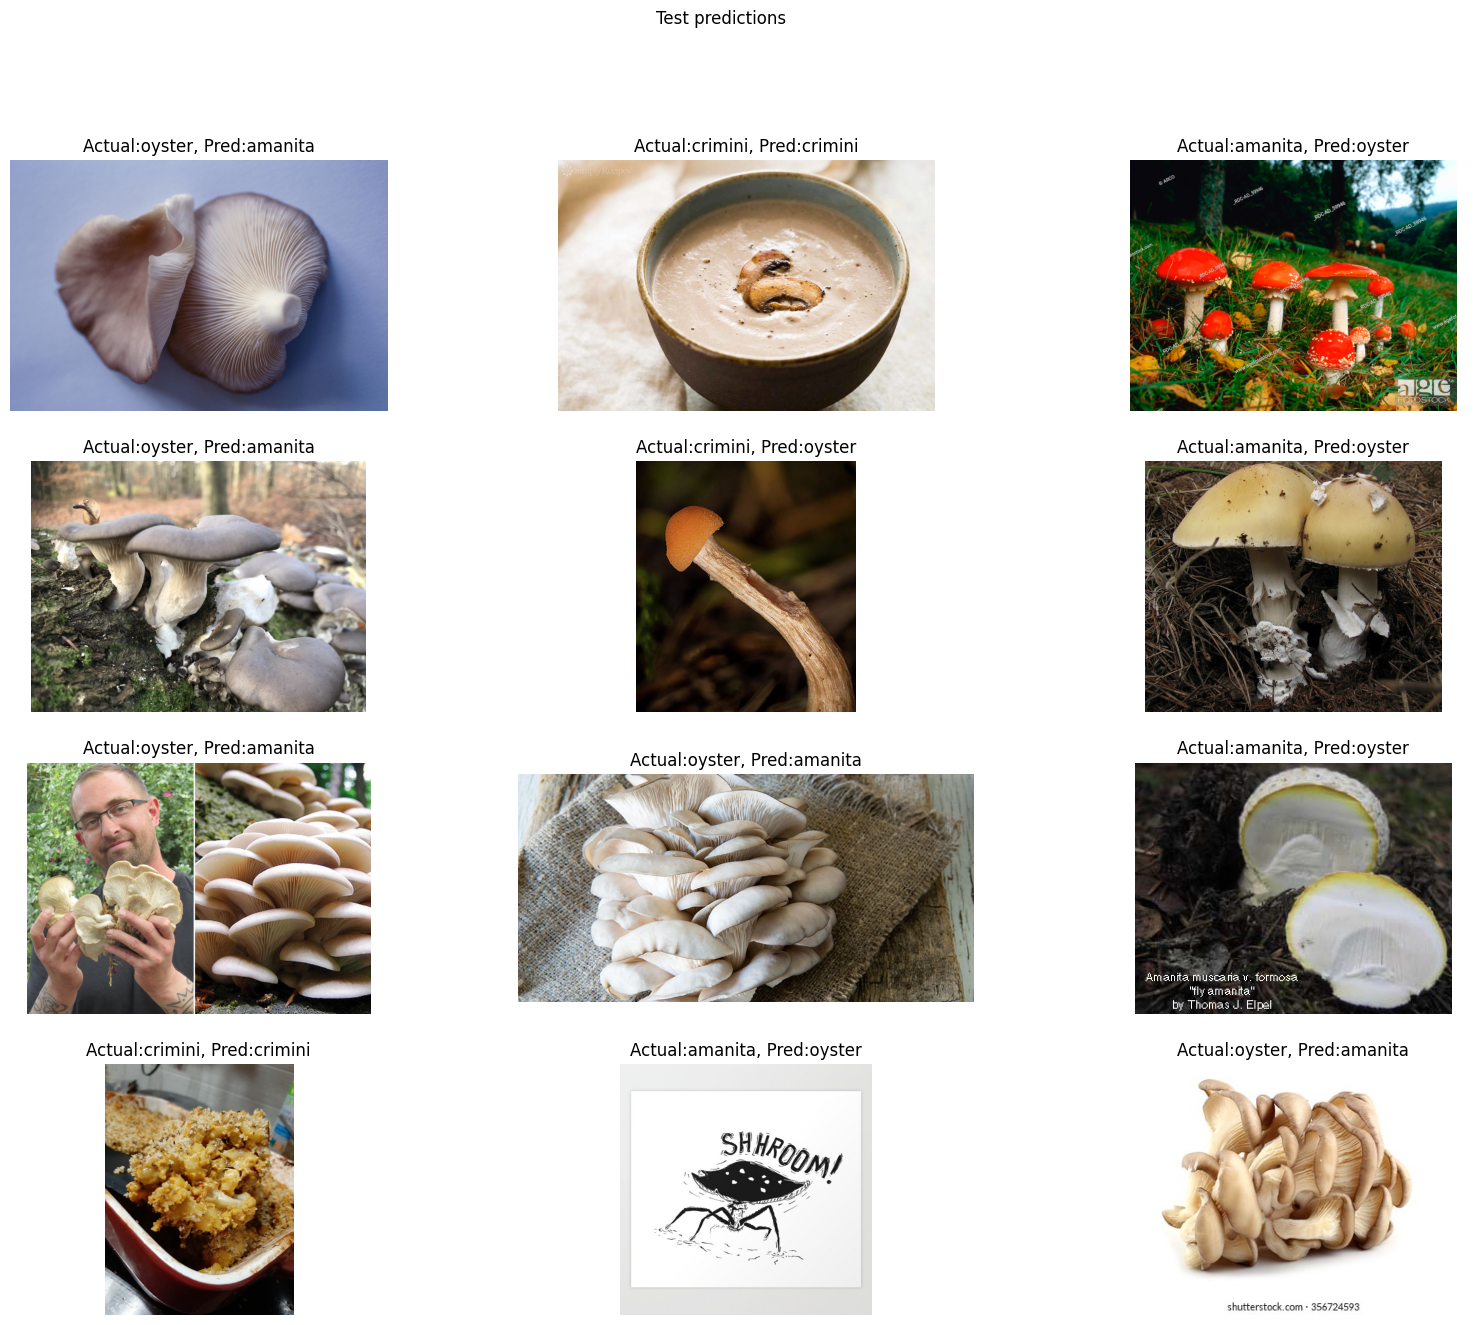

In [ ]:
# Generate a random sample of index
image_samples = np.random.randint(0,high=len(test_x)-1, size=12)
image_width = 224
image_height = 224
num_channels = 3

# Prepare the data
def preprocess_image(path):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=num_channels)
  image = tf.image.resize(image, [image_height, image_width])

  image = keras.applications.mobilenet.preprocess_input(image)

  return image

prediction_image_paths = [test_x[img_idx] for img_idx in image_samples]
# Prepare the data for prediction
prediction_data = tf.data.Dataset.from_tensor_slices((prediction_image_paths))
prediction_data = prediction_data.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
prediction_data = prediction_data.batch(len(prediction_image_paths))

# Make prediction
predictions = prediction_model.predict(prediction_data)
print("predictions.shape:",predictions.shape)
print(predictions[0],predictions[0].argmax())

fig = plt.figure(figsize=(20,15))
for i,img_idx in enumerate(image_samples):
    axs = fig.add_subplot(4,3,i+1)

    # Read image
    image = cv2.imread(test_x[img_idx])
    # convert to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)

    # Actual label vs prediction
    prediction_label = index2label[predictions[i].argmax()]
    axs.set_title("Actual:"+test_y[img_idx]+", Pred:"+prediction_label)


    plt.axis('off')

plt.suptitle("Test predictions")
plt.show()